# Classification
This notebook is based on Chapter 3: Classification from the book *Hands-On Machine Learning with Scikit-Learn, Keras, & Tensorflow* by Aurelien Geron.

## MNIST Dataset
Set of 70,000 small images of handwritten digits. 

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [0]:
# mnist['DESCR']      # Uncomment for complete description of the data

In [0]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape              # Each of the 70,000 images has 784 features which are the pixel intensity in 0 (white) to 155 (black) for each pixel in the 28 x 28 pixel image.

(70000, 784)

In [4]:
y.shape              # Labels

(70000,)

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

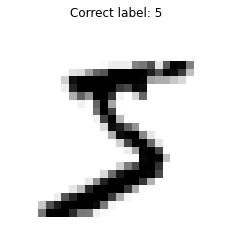

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.title('Correct label: ' + y[0])
plt.show()

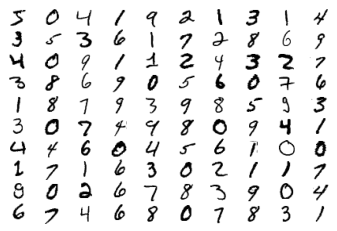

In [7]:
# Take a look at first 100 entries
fig, axes = plt.subplots(10,10)
ind = 0
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(X[ind].reshape(28,28), cmap='binary')
        axes[i,j].axis('off')
        ind += 1
plt.subplots_adjust(wspace=0, hspace=0)

In [0]:
# Recast labels from string to integer
y = y.astype(np.uint8)

Seperate the MNIST data into the training set (first 60,000 images) and the test set (last 10,000 images).  No peaking at the test set allowed, even by humans.

Note: the MNIST data is already broken into these training and test sets.  Further, the data is already shuffled in a random order. 



In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
Goal is to detect a single digit (say, 5 & not-5). 

In [0]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [11]:
# Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)      # set random state for reproducible results since SGD classifier relies on randomness (use random_state = 42 to get same results as comments)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
# See what the SGD Classifier detects for the first image (we know it is a 5)
sgd_clf.predict([X[0]])

array([ True])

## Performance Measures
### Cross Validation

In [0]:
# K-fold Cross Validation
from sklearn.model_selection import cross_val_score

In [14]:
K = 3               # number of folds
cross_val_score(sgd_clf, X_train, y_train_5, cv=K, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Above 93% accuracy on each fold isn't as impressive as it looks. Remember that the dataset has digits 0, 1, 2,..., 9, so just guessing 'not-5' each time turns out to be pretty good too. 

In [0]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [0]:
never_5_clf = Never5Classifier()

In [17]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=K, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

Key Takeaway: Don't use **accuracy** for skewed datesets where some classes are much more frequent than others.  Here, the 'not-5' class is much more frequent than the '5' class.  

### Confusion Matrix

In [0]:
from sklearn.model_selection import cross_val_predict

In [0]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 

In [0]:
from sklearn.metrics import confusion_matrix

In [21]:
# Confusion matrix
#   first row negative class: not-5s      TN | FP 
#   second row class: 5s                  FN | TP
confusion_matrix(y_train_5, y_train_pred)       

array([[53892,   687],
       [ 1891,  3530]])

In [22]:
# What perfection looks like
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision & Recall

**Precision** = TP / (TP + FP)<br>
Accuracy of the positive predictions

+----------------------------------------------+

**Recall** = TP / (TP + FN)<br>
Ratio of positive instances that are correctly detected<br>
AKA *sensitivity*, AKA *true positive rate* (TPR)

In [0]:
from sklearn.metrics import precision_score, recall_score

In [24]:
# Accuracy when it claims an image is a 5
precision_score(y_train_5, y_train_pred)    # == 4096 / (4096 + 1522)

0.8370879772350012

In [25]:
# Percent of 5's it detects
recall_score(y_train_5, y_train_pred)   # == 4096 / (4096 + 1325)

0.6511713705958311

**F<sub>1</sub> score:** harmonic mean penalizes low values so this unifies both metrics (precision and recall) but requires high scores of both to get high F<sub>1</sub> score. 

F<sub>1</sub> = 2 / ( (1/precision) + (1/recall) )<br>
              = 2 x (precision x recall) / (precision + recall)<br>
              = TP / (TP + ((FN+FP)/2))

In [0]:
from sklearn.metrics import f1_score

In [27]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

**Key Takeaway:**  The F<sub>1</sub> score favors classifiers that have similar precision and recall.  But sometimes you might care more about one or the other depending on the application.

**Key Takeaway: Precision/Recall tradeoff** -- You can't have it both ways. Increasing precision reduces recall, and vice versa.  

### Precision/Recall Trade-off

In [0]:
y_scores = sgd_clf.decision_function([some_digit])

In [31]:
y_scores

array([2164.22030239])

In [0]:
threshold = 0     # Default for SGDClassifier
y_some_digit_pred = (y_scores > threshold)

In [34]:
# Raise Threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [0]:
# Look at decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = 'decision_function')

In [0]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1],'g-', label = 'Recall')
    plt.legend()
    plt.xlabel('Threshold')
    plt.grid(b=False, axis = 'both', which='major', color='#666666', linestyle='-')

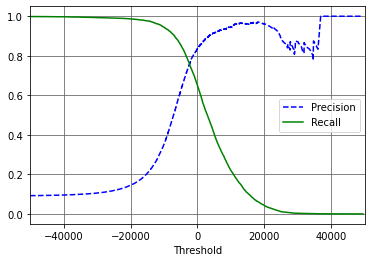

In [55]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim((-50000,50000))
plt.show()


In [0]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(precisions[:-1], recalls[:-1],'k-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(b=False, axis = 'both', which='major', color='#666666', linestyle='-')

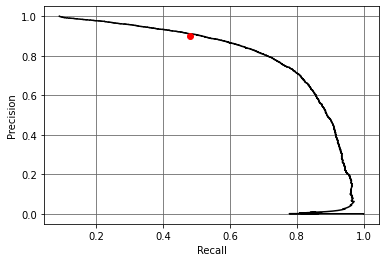

In [73]:
plot_precision_vs_recall(precisions,recalls)
plt.plot(0.48,0.90,'ro')
plt.show()

In [0]:
# Find lowest threshold that still gives at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]  # ~7816

# Make predictions on the training set
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [68]:
# Check these predictions' precision & recall
print('Precision: %0.4f | Recall: %0.4f ' 
      % (precision_score(y_train_5, y_train_pred_90),recall_score(y_train_5, y_train_pred_90)))

Precision: 0.9000 | Recall: 0.4800 


### ROC Curve
ROC: Receiving Operating Characteristic<br>
True Positive Rate (Recall) vs False Positive Rate<br>
FPR: ration of negative instances that are incorrectly classified as positive. <br>
FPR = 1 - TNR.  

TNR = *specifity*<br>
ROC Curve:  plots *sensitivity* (recall) vs 1-*specificity*

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid(b=False, axis = 'both', which='major', color='#666666', linestyle='-')

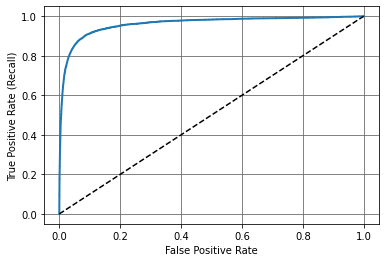

In [84]:
plot_roc_curve(fpr,tpr)
plt.show()

In [85]:
# ROC Area Under the Curve (AUC)
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Key Takeaways:**
*   Use Precision-Recall curve when positive class is rare or when you care more about false positives than false negatives. 
*   Otherwise, use ROC curve (and ROC AUC score). 



### Compare to alternate classifier
Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [0]:
y_scores_forest = y_probas_forest[:,1]    # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

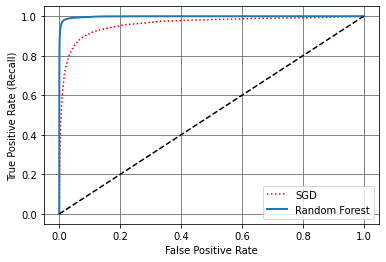

In [92]:
plt.plot(fpr, tpr, "r:", label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [93]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification
*    One-vs-One Strategy (requires *N* x (N-1)/2 classifiers
*    One-vs-All Strategy

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclassification task and selects the strategy based on the algorithm. 

In [0]:
from sklearn.svm import SVC

In [0]:
svm_clf = SVC()

In [99]:
# Train a Support Vector Machine (SVM) on the full MNIST training set
# Under the hood, it is using one-vs-one strategy due to the SVM algorithm
svm_clf.fit(X_train, y_train)   # y_train, not y_train_5

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [100]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [101]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [102]:
np.argmax(some_digit_scores)   

5

In [104]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Can force Scikit-Learn to use a specific strategy

In [0]:
from sklearn.multiclass import OneVsRestClassifier  

In [0]:
ovr_clf = OneVsRestClassifier(SVC())

In [0]:
ovr_clf.fit(X_train, y_train)

In [0]:
ovr_clf.predict([some_digit])

In [0]:
len(ovr.clf.estimators_)

Training a SGDClassifier (or RandomForestClassifier) is just as easy.

In [0]:
# SGDClassifiers can directly do multiclass so no OvO or OvR strategy decision needed.
sgd_clf.fit(Xtrain, y_train)
sgd_clf.predict([some_digit])

In [0]:
sgd_clf.decision_function([some_digit])

In [0]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

Simply scaling the inputs will increase the accuracy further. 

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit.transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = 'accuracy')